In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 10,10

import plotly.express as px
from sklearn import datasets
import random
from scipy.stats import multivariate_normal, norm
from sklearn.preprocessing import normalize
from sklearn.neighbors import KernelDensity
import sklearn.metrics as metrics

from utils import plot_decision_boundaries

# Generative Classification Methods
In supervised machine learning, the goal is to predict the class $y$ given the data $x$; i.e. we want to model $P(y=k/x)$. 
There are two ways to achieve this:

- Discriminative Classification : By directly modeling $P(y=k/x)$
- Generative Classification : By modeling $P(x/y=k)$ and then use Bayes theorem to get :

$P(y=k/x) = \dfrac{P(x/y=k)P(y=k)}{P(x)}$

Essentially generative models try to model the data generation process for each class; and weight it with the prior probability of observing
each class. In our setting for $K$ classes, we can use $P(x) = \displaystyle\sum_j^K P(x/y=j)P(y=j)$ in Bayes Theorom formulation, to get :

$P(y=k/x) = \dfrac{P(x/y=k)P(y=k)}{\displaystyle\sum_j^K P(x/y=j)P(y=j)}$

## Dataset
We will be using iris dataset in this demo. The dataset is comprised of 4 features of three types of iris species. The dataset is loaded and transformed to
a Pandas dataframe as follows :

In [2]:
iris = datasets.load_iris()

iris_df = pd.DataFrame(data=iris.data,columns=iris.feature_names)
iris_df['label'] = iris.target

# We create a dictionary; mapping numeric labels to text labels and apply it on 'label' column to get text labels 
target_names = {i:v for i,v in enumerate(iris.target_names)}
iris_df.label = iris_df.label.replace(target_names)
iris_df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),label
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


In [3]:
# Summary of features
iris_df.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


## Visualization
In the following you can visualize the dataset either in 2D or in 3D selecting two or three of the 4 features.

### 2D plots

In [4]:
feature_x = iris.feature_names[0]
feature_y = iris.feature_names[1]
feature_z = iris.feature_names[2]

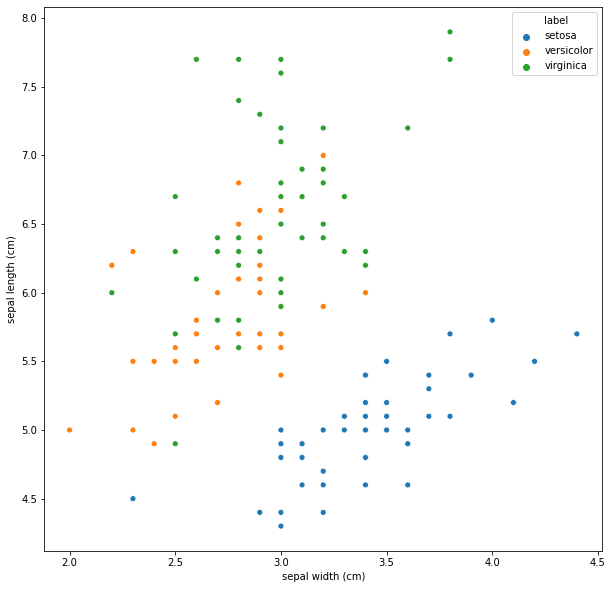

In [5]:
sns.scatterplot(y=iris_df[feature_x], x=iris_df[feature_y], hue=iris_df.label);

In [6]:
px.scatter_3d(iris_df,x=feature_x, y=feature_y, z=feature_z, color="label");

## Discriminant Analysis

In discriminant analysis, we model the generative process as a normal distribution with a separate mean for each class. 
If we assume that all four classes have same covariance matrix, we get **_Linear_ Discriminant Analysis (LDA)**. 
If however we model each class with its own covariance matrix
we get **_Quadratic_ Discriminant Analysis (QDA)**. In the following you will get to play with both. 

For LDA, we have
$$p(x \mid y=k)=\frac{1}{\pi^{\frac{p}{2}}|\Sigma|^{\frac{1}{2}}} \exp \left(-\frac{1}{2}\left(x-\mu_{k}\right)^{T} \Sigma^{-1}\left(x-\mu_{k}\right)\right)$$

where :
$$\begin{array}{l}
            \hat{\mu}_{k}=\frac{1}{n_{k}} \sum_{i: y^{(i)}=k} x^{(i)} \\
            \hat{\Sigma}=\frac{1}{n-g} \sum_{k=1}^{g} \sum_{i: y^{(i)}=k}\left(x^{(i)}-\hat{\mu}_{k}\right)\left(x^{(i)}-\hat{\mu}_{k}\right)^{T}
\end{array}$$

For QDA, we have a separate $ \Sigma_{k} $ for each class:
$$p(x \mid y=k)=\frac{1}{\pi^{\frac{p}{2}}\left|\Sigma_{k}\right|^{\frac{1}{2}}} \exp \left(-\frac{1}{2}\left(x-\mu_{k}\right)^{T} \Sigma_{k}^{-1}\left(x-\mu_{k}\right)\right)$$

where :
$$\begin{array}{l}
            \hat{\mu}_{k}=\frac{1}{n_{k}} \sum_{i: y^{(i)}=k} x^{(i)} \\
            \hat{\Sigma_{k}}=\frac{1}{n_k-1} \sum_{i: y^{(i)}=k}\left(x^{(i)}-\hat{\mu}_{k}\right)\left(x^{(i)}-\hat{\mu}_{k}\right)^{T}
        \end{array}$$

To train the model, we simply calculate the means for each class separately and the covariance either for the whole dataset (LDA) or each class separately (QDA).


In [7]:
means = iris_df.groupby('label').mean()
means_dict = dict(zip(iris.target_names,means.values)) # Creating a dictionary to contain mean vectors for all species
means_dict

{'setosa': array([5.006, 3.428, 1.462, 0.246]),
 'versicolor': array([5.936, 2.77 , 4.26 , 1.326]),
 'virginica': array([6.588, 2.974, 5.552, 2.026])}

In [8]:
cov_all = np.cov(iris.data.T)
cov_classwise = iris_df.groupby('label').cov()

cov_dict={label:cov_classwise.loc[label].to_numpy() for label in iris.target_names} # Creating a dictionary to contain covariance matrices for all species
cov_dict.update({'all':cov_all}) # Updating the dictionary with global covariance matrix for use in LDA
cov_dict

{'setosa': array([[0.12424898, 0.09921633, 0.0163551 , 0.01033061],
        [0.09921633, 0.1436898 , 0.01169796, 0.00929796],
        [0.0163551 , 0.01169796, 0.03015918, 0.00606939],
        [0.01033061, 0.00929796, 0.00606939, 0.01110612]]),
 'versicolor': array([[0.26643265, 0.08518367, 0.18289796, 0.05577959],
        [0.08518367, 0.09846939, 0.08265306, 0.04120408],
        [0.18289796, 0.08265306, 0.22081633, 0.07310204],
        [0.05577959, 0.04120408, 0.07310204, 0.03910612]]),
 'virginica': array([[0.40434286, 0.09376327, 0.3032898 , 0.04909388],
        [0.09376327, 0.10400408, 0.07137959, 0.04762857],
        [0.3032898 , 0.07137959, 0.30458776, 0.04882449],
        [0.04909388, 0.04762857, 0.04882449, 0.07543265]]),
 'all': array([[ 0.68569351, -0.042434  ,  1.27431544,  0.51627069],
        [-0.042434  ,  0.18997942, -0.32965638, -0.12163937],
        [ 1.27431544, -0.32965638,  3.11627785,  1.2956094 ],
        [ 0.51627069, -0.12163937,  1.2956094 ,  0.58100626]])}

The gaussian likelihood is implemented as follows :

In [9]:
def likelihood_matrix(x,mu,cov,dim=1):
    assert cov.shape==(dim,dim)
    assert x.shape==mu.shape

    if x.shape[0]!=dim:
        x=x.T 
        mu=mu.T

    mah_distance = (x-mu).T.dot(np.linalg.inv(cov)).dot(x-mu)
    exp_component = np.exp(-0.5*mah_distance)
    norm_component = np.pi**(dim/2)*np.sqrt(np.linalg.det(cov))

    return exp_component/norm_component

Then we create two dataframes, one each for LDA and QDA and calculate the likelihoods :

In [10]:
likelihood_lda = pd.DataFrame(columns=iris.target_names)
likelihood_qda = pd.DataFrame(columns=iris.target_names)

for sp in iris.target_names:
    for i in range(iris.data.shape[0]):
        likelihood_lda.loc[i,sp]=likelihood_matrix(iris.data[i,:],means_dict[sp],cov_dict['all'],dim=4)

for sp in iris.target_names:
    for i in range(iris.data.shape[0]):
        likelihood_qda.loc[i,sp]=likelihood_matrix(iris.data[i,:],means_dict[sp],cov_dict[sp],dim=4)

In [11]:
def generate_normal_data(sp,clf_type='lda'):
    if clf_type=='qda':
        return multivariate_normal.rvs(mean=means_dict[sp],cov=cov_dict[sp],size=1000)
    elif clf_type=='lda':
        return multivariate_normal.rvs(mean=means_dict[sp],cov=cov_dict['all'],size=1000)

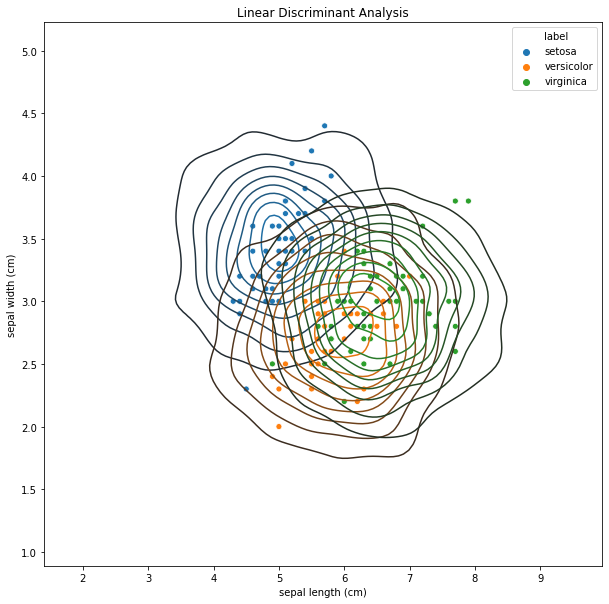

In [12]:
ax1 = sns.scatterplot(x=iris_df['sepal length (cm)'], y=iris_df['sepal width (cm)'], hue=iris_df.label)
plt.title('Linear Discriminant Analysis')
for sp in iris.target_names:
    sns.kdeplot(generate_normal_data(sp,'lda')[:,0],
                generate_normal_data(sp,'lda')[:,1],ax=ax1)

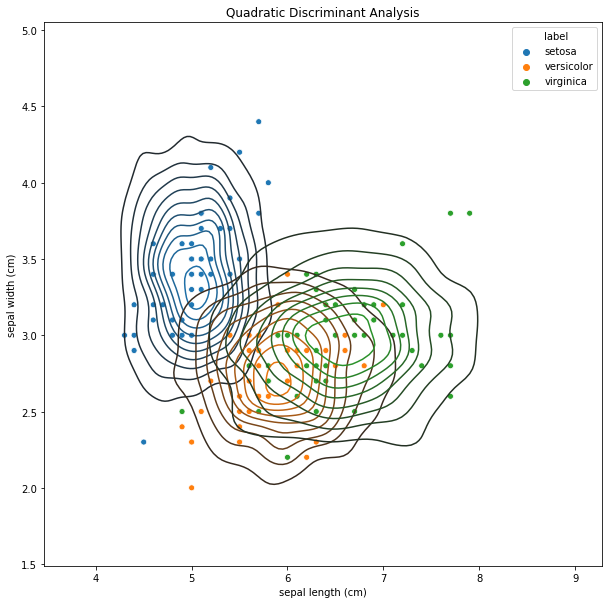

In [13]:
ax2=sns.scatterplot(x=iris_df['sepal length (cm)'], y=iris_df['sepal width (cm)'], hue=iris_df.label)
plt.title('Quadratic Discriminant Analysis')
for sp in iris.target_names:
    sns.kdeplot(generate_normal_data(sp,'qda')[:,0],
                generate_normal_data(sp,'qda')[:,1],ax=ax2)

## Naive Bayes Classifiers

In almost all cases, the features in a dataset are not independent; however if we make the _naive_ assumption that all features are 
conditionally independent, we arrive at the appropriately named **Naive Bayes** classifiers. 
Thus given the class of the target, the joint density/likelihood of all the features is just the product of the
univariate densities of each separate feature (i.e., the features are **independent** given y).

$$p(x \mid y=k)=\prod_{j=1}^{p} p\left(x_{j} \mid y=k\right)$$

We will experiment with following types of likelihood functions:
- Gaussian Likelihood
- Kernelized Densities
- Categorical features

### Gaussian Likelihood
In the Iris dataset, we have 4 features, hence the likelihood will be product of 4 gaussians with each guassian calculated from
one feature for each class. Since we have already calculated the means and covariance matrices previously, we make use of that and 
note that the 4 variances for each feature are the diagonal entries of a covariance matrix. Thus, for example, for class _setosa_, we get

In [14]:
print(f"mean values of all features for setosa : {means.loc['setosa'].values}")
cov_classwise.loc['setosa']
print(f"variance values of all features for setosa : {np.diag(cov_classwise.loc['setosa'].values)}")

mean values of all features for setosa : [5.006 3.428 1.462 0.246]
variance values of all features for setosa : [0.12424898 0.1436898  0.03015918 0.01110612]


#### Train-Test Split
Here we show how to split a dataset randomly into train and test sets. This is just for demonstration purpose. For routine use, sklearn has a utility function *train_test_split*

In [15]:
train_ratio = 0.9
data_size = len(iris_df)

train_mask = np.random.choice([True,False],size=data_size, p=[train_ratio,1-train_ratio])
train_data = iris_df[train_mask]
test_data = iris_df[~train_mask]

To capture all the parameters in a data structure which can be used conveniently later on, we use a Multi Index Dataframe like so:

In [16]:
row_index = pd.MultiIndex.from_product([iris.target_names,['mean','var']], names=['specie','param'])
parameter_df = pd.DataFrame(np.zeros((4,6)),columns= row_index, index = iris.feature_names)

for specie in iris.target_names:
    parameter_df.T.loc[(specie,'mean')] = means.loc[specie].values # For explanation of why I used transpose, see https://pandas.pydata.org/pandas-docs/stable/user_guide/advanced.html#advanced-indexing-with-hierarchical-index
    parameter_df.T.loc[(specie,'var')] = np.diag(cov_classwise.loc[specie].values)

parameter_df=parameter_df.T.sort_index()
parameter_df

sepal length (cm)  sepal width (cm)  petal length (cm)  \
specie     param                                                           
setosa     mean            5.006000          3.428000           1.462000   
           var             0.124249          0.143690           0.030159   
versicolor mean            5.936000          2.770000           4.260000   
           var             0.266433          0.098469           0.220816   
virginica  mean            6.588000          2.974000           5.552000   
           var             0.404343          0.104004           0.304588   

                  petal width (cm)  
specie     param                    
setosa     mean           0.246000  
           var            0.011106  
versicolor mean           1.326000  
           var            0.039106  
virginica  mean           2.026000  
           var            0.075433

To calculate Naive Bayes likelihood for any sample, we make use of the gaussian pdf evaluation function for a given sample and the parameter dataframe from above.

In [17]:
def gaussian_prob(x,mu,var):

    residual = x-mu
    exp_component = np.exp(-0.5*(residual**2)/var)
    norm_component = np.sqrt(np.pi*var)

    return exp_component/norm_component

def naive_bayes(x,parameter_df):
    class_likelihood = {}
    for specie in iris.target_names:
        likelihood_val = 1.0
        for i,feature in enumerate(iris.feature_names):
            mu = parameter_df.loc[specie,'mean'][feature]
            var = parameter_df.loc[specie,'var'][feature]
            l = gaussian_prob(x[i],mu,var)
            likelihood_val=likelihood_val*l
        class_likelihood[specie]=likelihood_val

    return class_likelihood

Here I will show the result for 10 randomly sampled datapoints

In [18]:
for i in np.random.randint(150,size=10):
    x = iris.data[i]
    true_label = iris.target_names[iris.target[i]]

    likelihood = naive_bayes(x,parameter_df)
    evidence = sum(likelihood.values())
    posterior = {label:likelihood/evidence for label,likelihood in likelihood.items()}
    pred_label,pred_prob = max(posterior.items(), key=lambda x:x[1])
    print(f"{i} : {pred_label} : {pred_prob} : {pred_label==true_label}")

26 : setosa : 0.9999999999999681 : True
102 : virginica : 0.9999997672512252 : True
21 : setosa : 0.9999999999999988 : True
99 : versicolor : 0.9998204273691992 : True
101 : virginica : 0.9727559387129939 : True
84 : versicolor : 0.99182974026217 : True
75 : versicolor : 0.9865371892564887 : True
49 : setosa : 1.0 : True
42 : setosa : 1.0 : True
65 : versicolor : 0.9787587465044743 : True


### Naive Bayes with Kernelized Densities

In the section above, we assumed that the class-conditional distribution of each and every numerical feature
could be modeled sufficiently well with a Gaussian density. What can we do if this does not hold or we just
generally want more flexibility?

One way to do so is to use a kernel density estimate of the empirical class-conditional distributions of the
features as likelihoods. Let’s begin by checking out what the kernel density estimate of the Sepal.Width
feature looks like with the Gaussian and the Triangular kernel functions:

In [48]:
sepal_width = iris_df['sepal width (cm)'].values#.reshape(-1,1)
sepal_length = iris_df['sepal length (cm)'].values#.reshape(-1,1)

In [56]:
kde_gaussian = KernelDensity(kernel='gaussian',bandwidth=0.1822).fit(sepal_width.reshape(-1,1))
kde_triangular = KernelDensity(kernel='linear',bandwidth=0.1822).fit(sepal_width.reshape(-1,1))

In [57]:
X_plot = np.linspace(2, 5, 1000)[:, None]

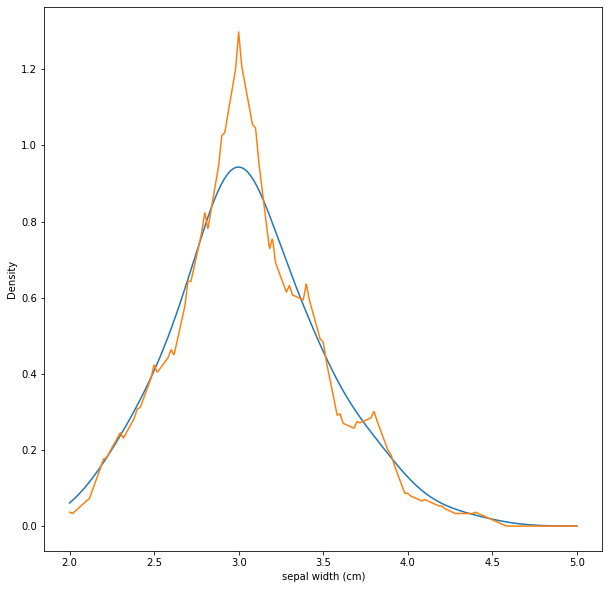

In [58]:
plt.plot(X_plot,np.exp(kde_gaussian.score_samples(X_plot)))
plt.plot(X_plot,np.exp(kde_triangular.score_samples(X_plot)))
plt.xlabel('sepal width (cm)')
plt.ylabel('Density');

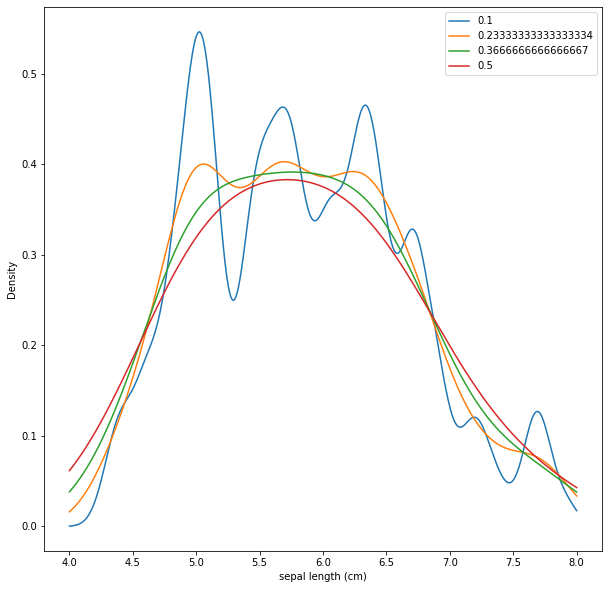

In [59]:
X_plot_bw = np.linspace(4, 8, 1000)[:, None]
for bw in np.linspace(0.1,0.5,4):
    kde_gaussian_bw = KernelDensity(kernel='gaussian',bandwidth=bw).fit(sepal_length.reshape(-1,1))
    plt.plot(X_plot_bw,np.exp(kde_gaussian_bw.score_samples(X_plot_bw)))
plt.legend(np.linspace(0.1,0.5,4))
plt.xlabel('sepal length (cm)')
plt.ylabel('Density');

We see that with a broader kernel width (i.e., higher bandwidth bw) the density estimate becomes smoother,
but smaller features are lost.

We extend our Naive Bayes framework with the ability to use kernel density estimates and see how it
performs on our training data:

In [60]:
def naive_bayes_kde(X_train_df,X_test_df,kernel='gaussian',bw=0.5):
    class_likelihood = {}
    for specie in iris.target_names:
        likelihood_val = np.ones((X_test_df.shape[0],))
        for i,feature in enumerate(iris.feature_names):
            X_train = X_train_df.query('label==@specie').loc[:,feature]
            X_test = X_test_df.loc[:,feature]
            kde = KernelDensity(kernel=kernel,bandwidth=bw).fit(X_train.values.reshape(-1,1))
            likelihood = np.exp(kde.score_samples(X_test.values.reshape(-1,1)))
            likelihood_val = np.multiply(likelihood_val,likelihood)
        class_likelihood[specie]=likelihood_val
    return pd.DataFrame.from_dict(class_likelihood)

In [63]:
class_likelihood = naive_bayes_kde(iris_df,iris_df,kernel='gaussian',bw=0.5)
class_prob = class_likelihood.div(class_likelihood.sum(axis=1),axis=0)

In [65]:
class_prob['prediction'] = class_prob.idxmax(axis=1)
class_prob['label']=iris_df.label

In [68]:
metrics.confusion_matrix(class_prob.label,class_prob.prediction,labels=iris.target_names)

array([[50,  0,  0],
       [ 0, 48,  2],
       [ 0,  5, 45]])

## Additional material: Naive Bayes with categorical predictors

If a task includes categorical features, the assumption that the feature vector comes from Gaussian distributions that LDA and QDA and standard Naive Bayes rely on don’t make any sense anymore. For the Naive Bayes classifier, however, we can simply use multinomial densities for such categorical features.

To see how well this can work, we turn Sepal.Length into a categorical feature and use this as a new feature instead:

In [69]:
iris_df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),label
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


In [75]:
iris_df['sepal length types']=pd.qcut(iris_df['sepal length (cm)'],q=[0,.25, .75, 1])

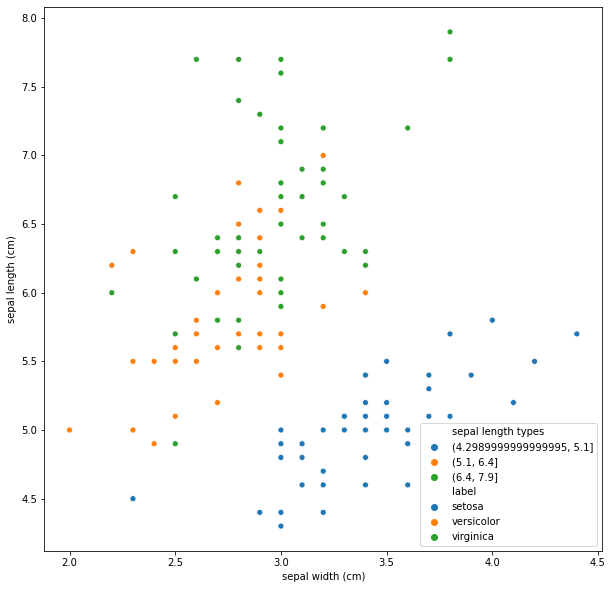

In [81]:
sns.scatterplot(x='sepal width (cm)',y='sepal length (cm)',hue = 'sepal length types',data=iris_df);
sns.scatterplot(x='sepal width (cm)',y='sepal length (cm)',hue = 'label',data=iris_df);